### Example: KDE on a Sphere

• Perhaps the most common use of KDE is in graphically representing distributions of points.

• For example, in the Seaborn visualization library (see Visualization With Seaborn), KDE is built in and automatically used to help visualize points in one and two dimensions.

• Here we will look at a slightly more sophisticated use of KDE for visualization of distributions.

• We will make use of some geographic data that can be loaded with Scikit-Learn: the geographic distributions of recorded observations of two South American mammals, Bradypus variegatus (the Brown-throated Sloth) and Microryzomys minutus (the Forest Small Rice Rat).

• Let's begine with the standard import

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

• With Scikit-Learn, we can fetch this data as follows:

In [2]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/array of species IDs & locations
latlon = np.vstack([data.train['dd lat'],
                   data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype='int')

• With this data loaded, we can use the Basemap toolkit (mentioned previously in Geographic Data with Basemap) to plot the observed locations of these two species on the map of South America.

/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


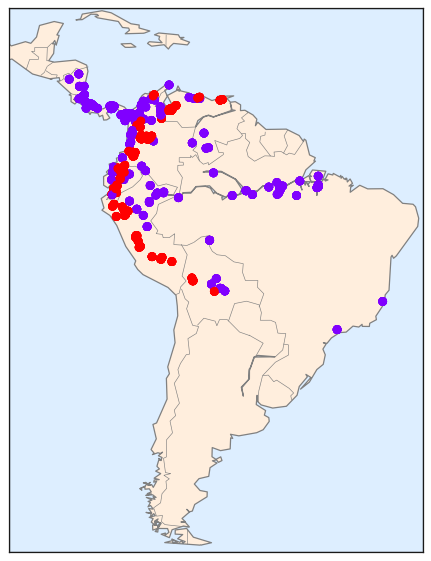

In [11]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 8), dpi=90, facecolor='w', edgecolor='k')

xgrid, ygrid = construct_grids(data)

# Plot coastline with basemap
m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# Plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
         c=species, cmap='rainbow', latlon=True);

• Unfortunately, this doesn't give a very good idea of the density of the species, because points in the species range may overlap one another.

• You may not realize it by looking at this plot, but there are over 1,600 points shown here!

• Let's use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map.

• Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the haversine distance metric, which will correctly represent distances on a curved surface.

• There is a bit of boilerplate code here (one of the disadvantages of the Basemap toolkit) but the meaning of each code block should be clear:

/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/rajesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


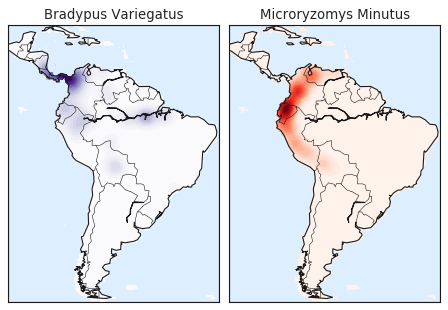

In [31]:
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import figure

# Setup the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_refference = data.coverages[6][::5, ::5]
land_mask = (land_refference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(6, 12), dpi=80)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # Plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
               urcrnrlat=Y.max(), llcrnrlon=X.min(),
               urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()

    # Construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    # Evaluate only on the land
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # Plot contour of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

• Compared to the simple scatter plot we initially used, this visualization paints a much clearer picture of the geographical distribution of observations of these two species.